<a href="https://colab.research.google.com/github/Aathib/Repo1/blob/master/Colab's_New_Code_Editor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aathibala","key":"b14151cdbf16ac89d2f93240f6e1f724"}'}

In [19]:
import os
os.listdir()

['.profile',
 '.bashrc',
 '.ipython',
 '.kaggle',
 '.local',
 'kaggle.json',
 '.keras',
 '.cache',
 '.config',
 '.npm',
 '.jupyter',
 '.node-gyp',
 '.gsutil']

In [0]:
!mkdir .kaggle

In [13]:
cd root

/root


In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [23]:
!kaggle competitions download -c 'ieee-fraud-detection'
! mkdir train
! unzip train_transaction.csv.zip -d train
! unzip test_transaction.csv.zip -d test
os.chdir('train')

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 108MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 108MB/s]
 63% 33.0M/52.2M [00:00<00:00, 40.3MB/s]
100% 52.2M/52.2M [00:00<00:00, 96.8MB/s]
 84% 49.0M/58.3M [00:03<00:01, 5.94MB/s]
100% 58.3M/58.3M [00:03<00:00, 18.4MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 161MB/s]
Archive:  train_transaction.csv.zip
  inflating: train/train_transaction.csv  
Archive:  test_transaction.csv.zip
  inflating: test/test_transaction.csv  


In [24]:
import pandas as pd
import numpy as np
!pip install catboost
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, auc
import xgboost as xgb
import os
import time
from xgboost import XGBClassifier
from hyperopt import hp, tpe, STATUS_OK, Trials, fmin
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 5

     |████████████████████████████████| 64.0MB 48kB/s 


In [0]:
train = pd.read_csv('train_transaction.csv')

In [11]:
(train.isnull().sum()/len(train)*100)

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
                    ...    
V335              86.054967
V336              86.054967
V337              86.054967
V338              86.054967
V339              86.054967
Length: 394, dtype: float64

In [0]:
a = train.isnull().sum()/len(train)*100
# saving column names in a variable
variables = train.columns
variable = [ ]
for i in range(0,394):
    if a[i]>=50:   #setting the threshold as 30%
        variable.append(variables[i])


In [0]:
train.drop(variable, axis = 1, inplace = True)

In [28]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=220)

In [0]:
#data.head()
X =train.drop('isFraud', axis = 1)
X.fillna(-999,inplace = True)
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=143)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=143)
categorical_features_indices = np.where(X.dtypes != np.float)[0]
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [30]:
model1 = CatBoostClassifier(random_seed=143,
                            iterations = 5000,
                            learning_rate = 0.35,
                            bootstrap_type='Bernoulli', 
                            subsample=1,
                            
                            leaf_estimation_iterations = 5, 
                            logging_level='Silent', 
                            early_stopping_rounds=10,
                            eval_metric= 'AUC',
                            use_best_model = True, task_type = "GPU")
model1.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
    #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)
predictions = model1.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
clss = classification_report(y_test, predictions)
print(clss)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     85469
           1       0.89      0.59      0.71      3112

    accuracy                           0.98     88581
   macro avg       0.94      0.79      0.85     88581
weighted avg       0.98      0.98      0.98     88581



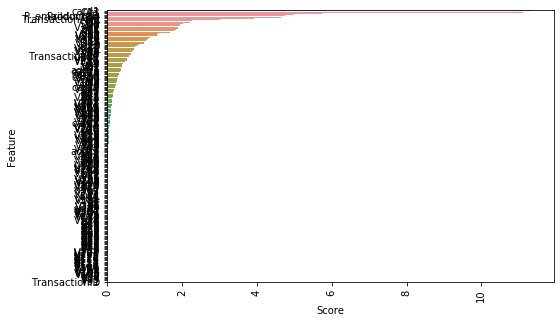

In [32]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, model1.get_feature_importance(train_pool))),columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
import seaborn as sns
plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
sns.barplot(feature_score['Score'],feature_score['Feature'])

In [0]:
feature_score1 = feature_score[feature_score['Score']>1]

In [0]:
X = train[feature_score1['Feature'].values]

In [0]:
X.fillna(-999,inplace = True)
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=143)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=143)
categorical_features_indices = np.where(X.dtypes != np.float)[0]
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [36]:
model2 = CatBoostClassifier(random_seed=143,
                            iterations = 5000,
                            learning_rate = 0.35,
                            bootstrap_type='Bernoulli', 
                            subsample=1,
                            leaf_estimation_iterations = 5, 
                            logging_level='Silent', 
                            early_stopping_rounds=10,
                            eval_metric= 'AUC',
                            use_best_model = True, task_type = "GPU")
model2.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
    #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)
predictions = model2.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
clss = classification_report(y_test, predictions)
print(clss)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     85469
           1       0.90      0.60      0.72      3112

    accuracy                           0.98     88581
   macro avg       0.94      0.80      0.85     88581
weighted avg       0.98      0.98      0.98     88581



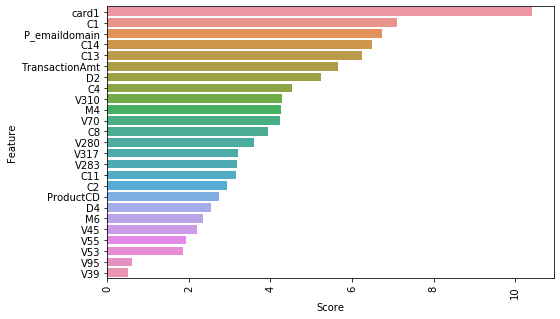

In [38]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, model2.get_feature_importance(train_pool))),columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
import seaborn as sns
plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
sns.barplot(feature_score['Score'],feature_score['Feature'])

In [0]:
feature_score2 = feature_score[feature_score['Score']>1]

In [0]:
X = train[feature_score2['Feature'].values]

In [0]:
X.fillna(-999,inplace = True)
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=143)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=143)


categorical_features_indices = np.where(X.dtypes != np.float)[0]
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [0]:

categorical_features_indices = np.where(X.dtypes != np.float)[0]
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [43]:
model3 = CatBoostClassifier(random_seed=143,
                            iterations = 5000,
                            learning_rate = 0.3,
                            bootstrap_type='Bernoulli', 
                            subsample=1,
                            depth = 12,
                            leaf_estimation_iterations = 5, 
                            logging_level='Silent', 
                            early_stopping_rounds=20,
                            eval_metric= 'AUC',
                            use_best_model = True, task_type = "GPU")
model3.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
    #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)
predictions = model3.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
clss = classification_report(y_test, predictions)
print(clss)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     85469
           1       0.90      0.66      0.76      3112

    accuracy                           0.99     88581
   macro avg       0.95      0.83      0.88     88581
weighted avg       0.98      0.99      0.98     88581



In [53]:
!ls

catboost_info  train_transaction.csv


In [0]:
test = pd.read_csv('test_transaction.csv')

In [0]:
test1 = test[X_train.columns]

In [0]:
test1.fillna(-999, inplace = True)
predict_val = model3.predict(test1)

In [0]:
subt = test['TransactionID']
test['isfraud'] = predict_val
subtt = test['isfraud']

In [0]:
sub = pd.concat([subt, subtt], axis =1)

In [0]:
sub.to_csv('submission1.csv', index_label=False)

In [90]:
!kaggle competitions submit -c ieee-fraud-detection -f submission1.csv -m "catbst"

100% 8.11M/8.11M [00:02<00:00, 3.44MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [83]:
sub.head()

,TransactionID,isfraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
